In [19]:
bf_data_cdf = '/home/benr/wqmodels/ssm/freshwater_iav_1/results/buoyfreq.nc'
bf_variables = ('q0.1','control',)
control_variable = 'control'
out_path = '/home/benr/wqmodels/ssm/freshwater_iav_1/results/buoyfreq/'

grid_file = 'SSM_Grid/ssm_grid.2dm'

sites = {
    6231: "ADM001",
    8908: "Pt Jefferson",
    9516: "Saratoga",
    14410: "Carr Inlet",
    15798: "Budd Inlet",
    #13869: "Twanoh",
    #10170: "Seabeck",
    11199: "Dabob",
    #11310: "Triton Cove",
    13095: "Hoodsport",
    14019: "Lynch Cove",
    11899: 'Inside Skagit R'
}

from pathlib import Path
import os.path as path
import os
from multiprocessing import Pool
from netCDF4 import Dataset
import geopandas as gpd
import pandas as pd
import numpy as np
from psutil import cpu_count
import scipy.interpolate as interp
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import cmocean
import matplotlib.colors as colors

from fvcom.grid import FvcomGrid
from fvcom.depth import DepthCoordinate
from fvcom.control_volume import ControlVolume, StationHelper

In [21]:
bf_data = Dataset(bf_data_cdf)
bf_data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    model_start: 2012-01-01 00:00:00
    dimensions(sizes): time(10969), node(6052), nele(9012)
    variables(dimensions): int32 node(node), float32 h(node), float32 x(node), float32 y(node), int32 nele(nele), float32 time(time), float32 controlzeta(time, node), float32 controlN2_max(time, node), float32 q0.1zeta(time, node), float32 q0.1N2_max(time, node), float32 q0.3zeta(time, node), float32 q0.3N2_max(time, node), float32 q0.5zeta(time, node), float32 q0.5N2_max(time, node), float32 q0.7zeta(time, node), float32 q0.7N2_max(time, node), float32 q0.9zeta(time, node), float32 q0.9N2_max(time, node)
    groups: 

In [22]:
model_start = pd.Timestamp(bf_data.model_start)
times = bf_data['time'][:]
dates = model_start + pd.to_timedelta(times, 'd')

In [4]:
grid = FvcomGrid.from_mesh(grid_file)
cv = ControlVolume(grid=grid, nodes=set(bf_data['node'][:]), calc=True)

In [27]:
bf_variable_titles = bf_variables
control_title = control_variable
variable_type_name = 'Max'
print(f'Control is {control_title}')
bf_variable_titles

Control is control


('q0.1', 'control')

In [28]:
control_variable += 'N2_max'
bf_variables = [v + 'N2_max' for v in bf_variables]

In [7]:
out_base = Path(bf_data_cdf).stem
if not path.isdir(out_path):
    os.mkdir(out_path)
out_file = lambda name: path.join(out_path, out_base + "_n2_" + name)

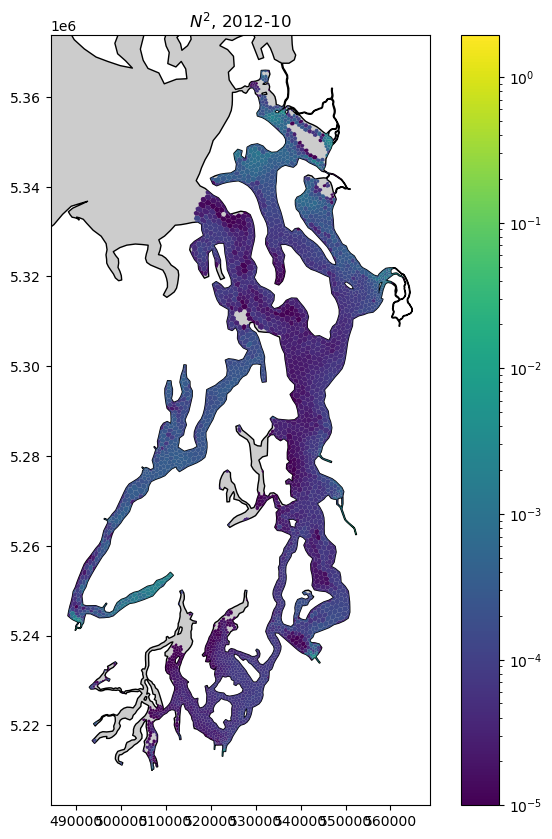

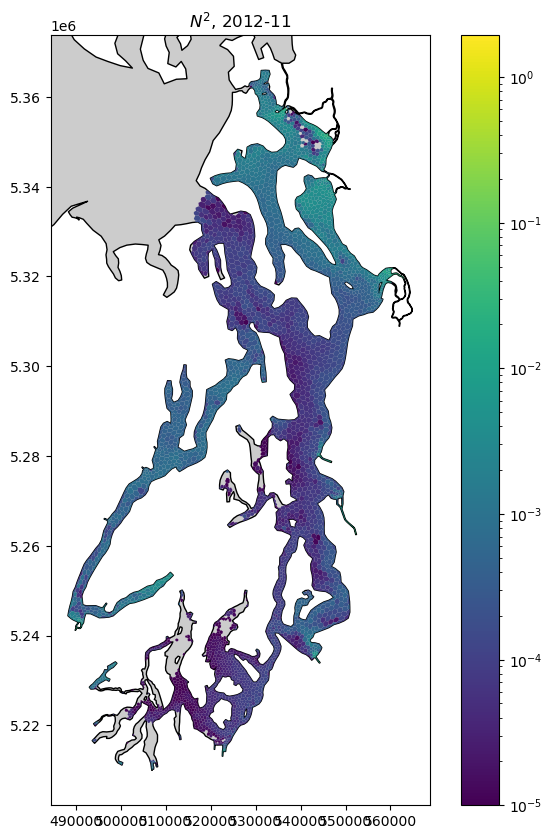

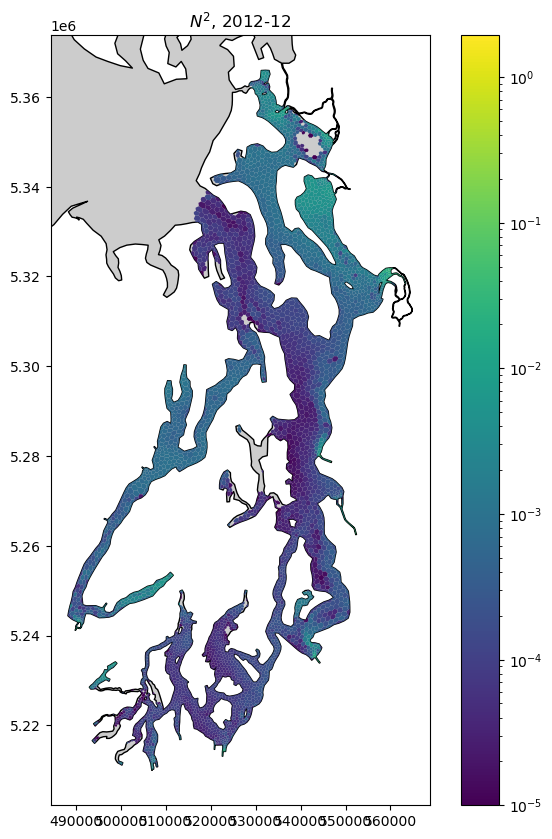

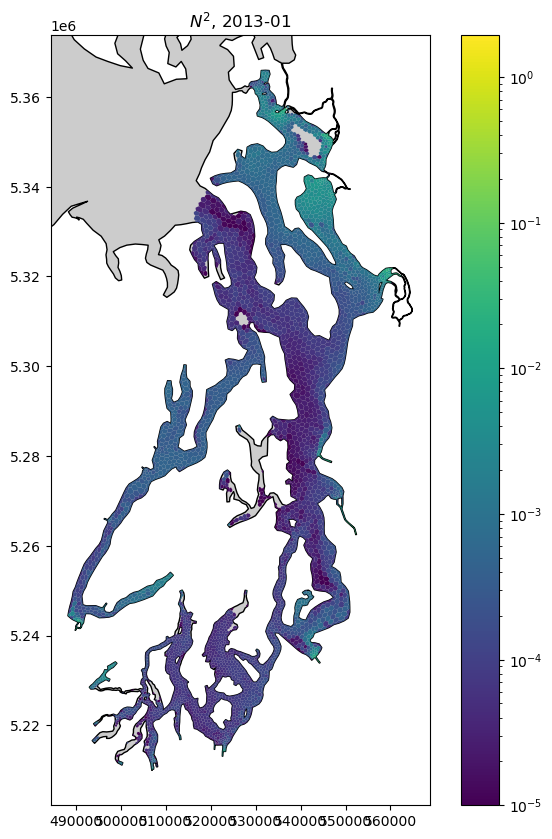

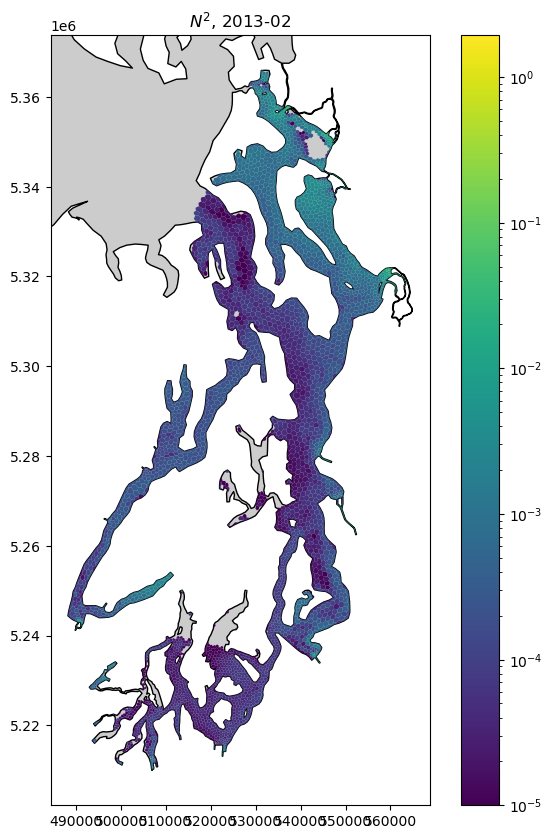

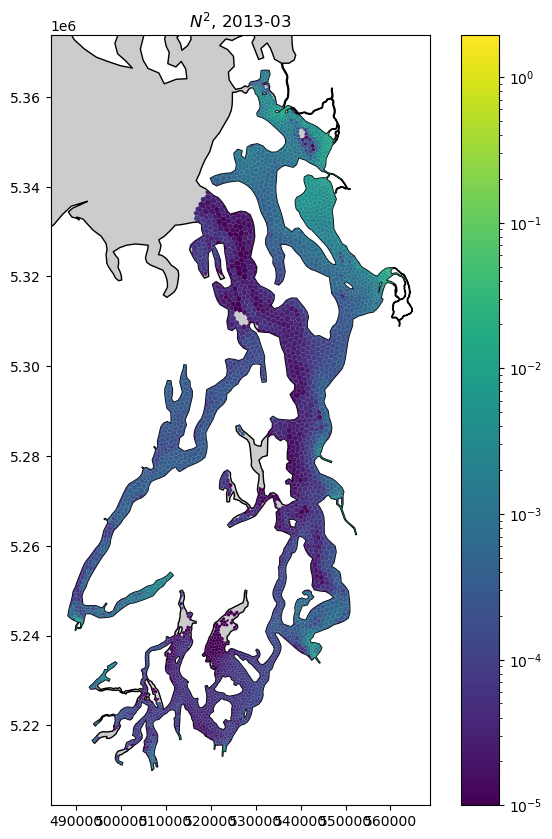

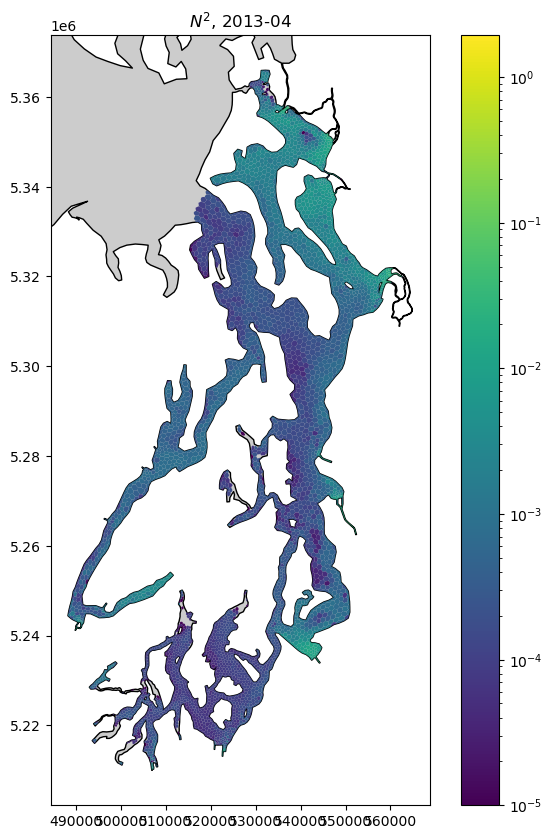

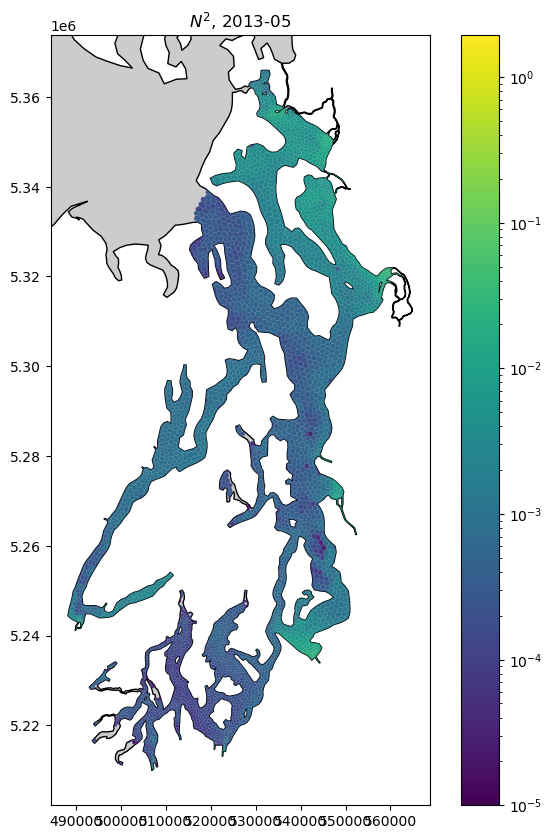

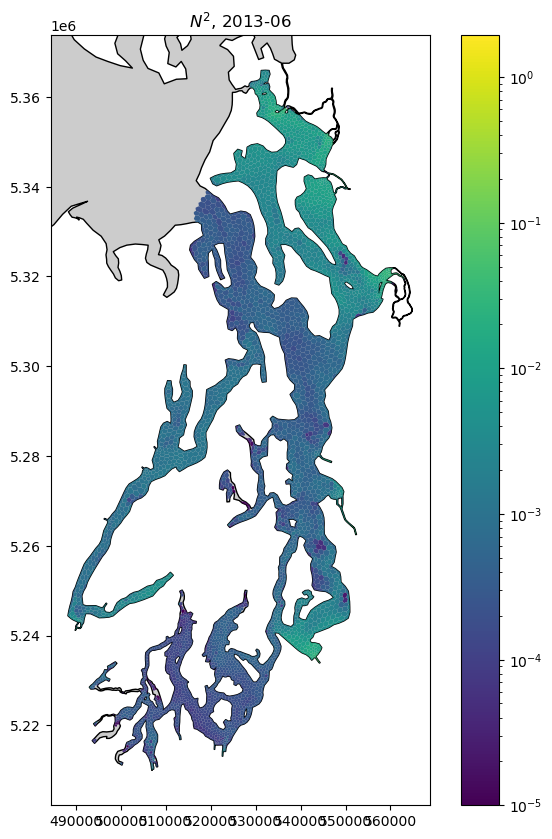

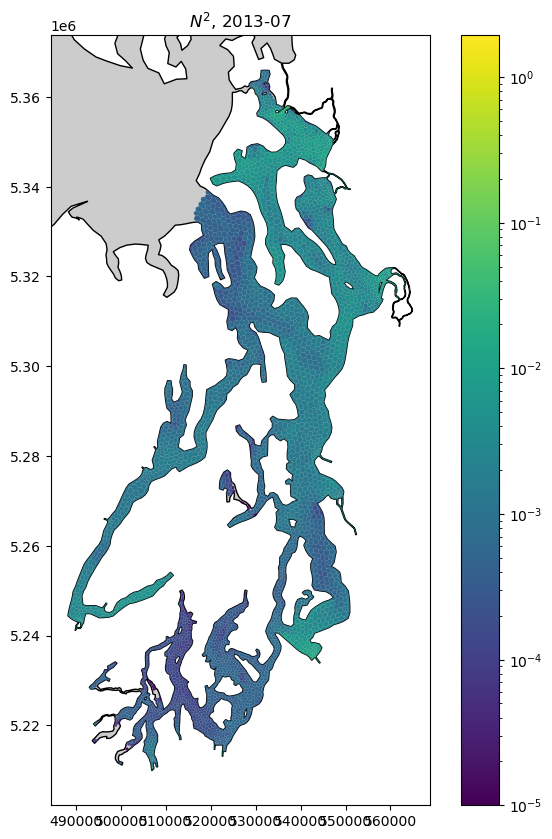

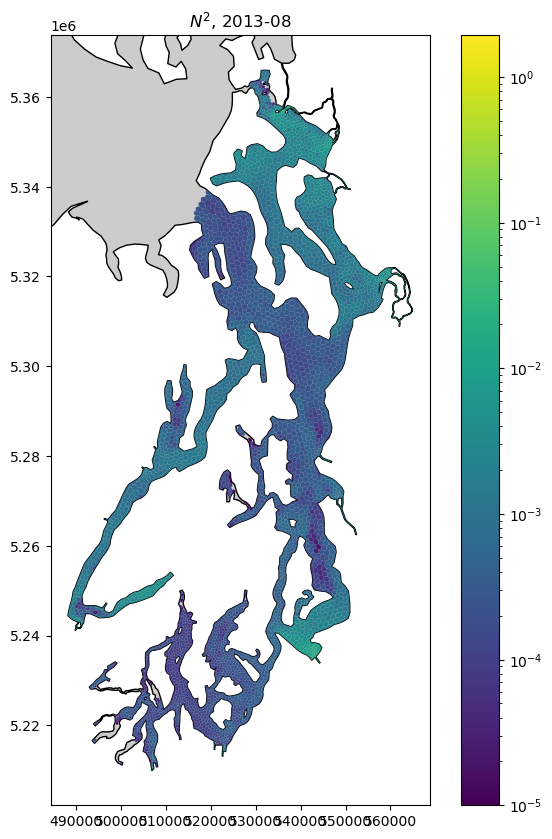

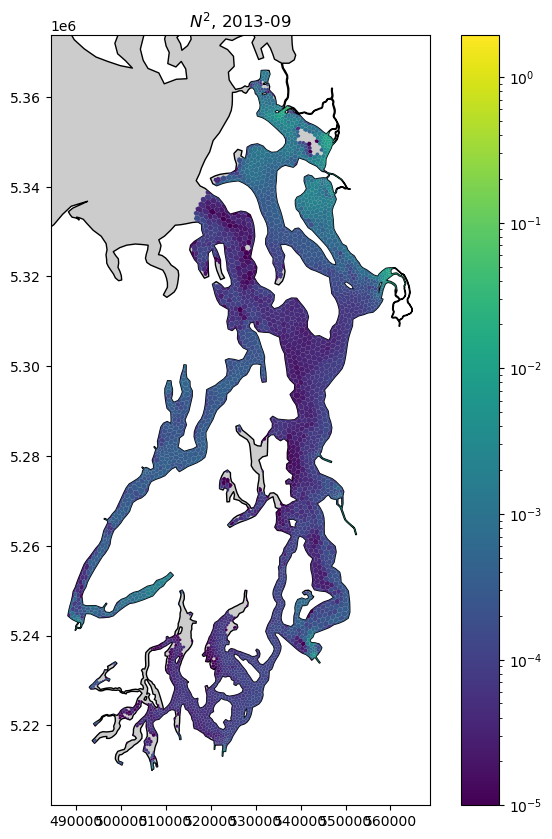

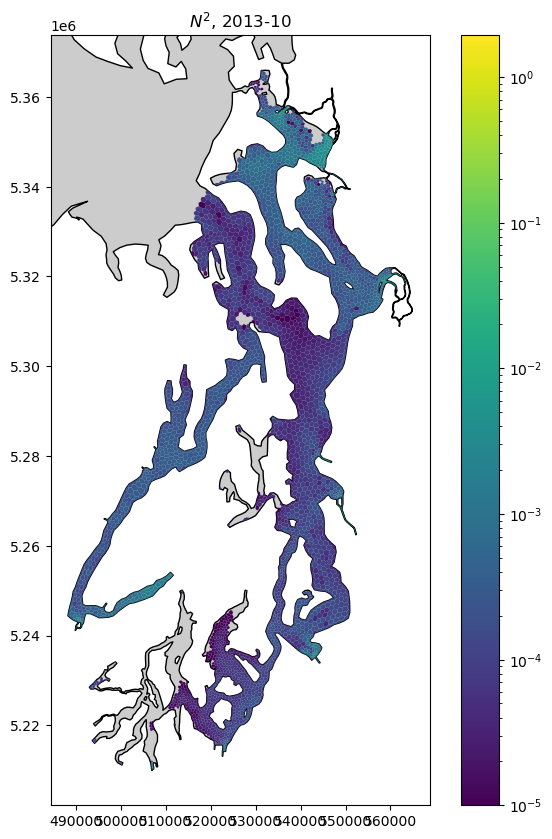

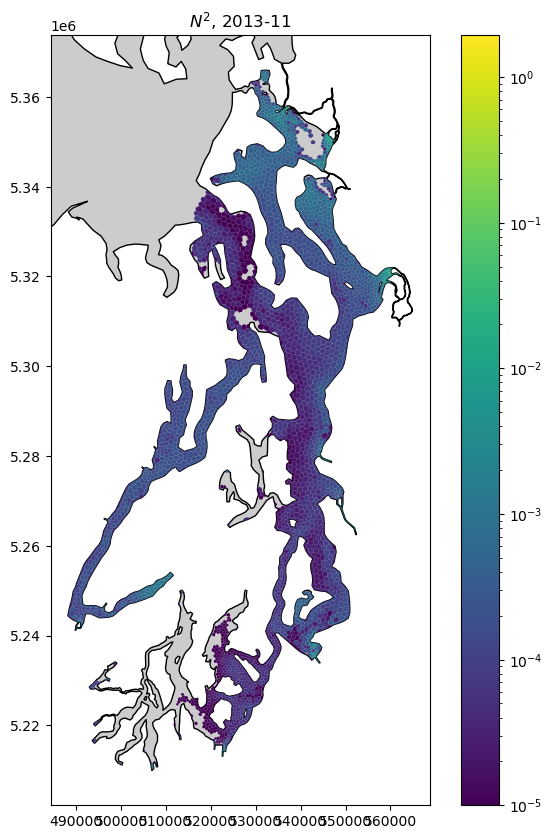

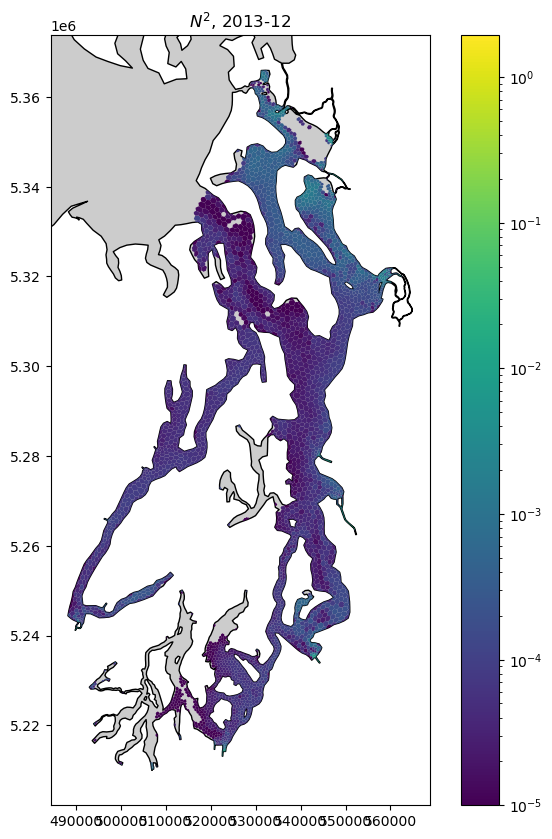

In [31]:
# Plot control N^2 spatially to see variation
datesdf = pd.DataFrame({'date': dates})
datesdf['count'] = datesdf.index
datesdf.set_index('date', inplace=True)
v = bf_data[control_variable]
vmax = v[:].max()
vmin = v[:].min()
for d,group in datesdf.resample('ME'):
    if len(group) == 1:
        continue
    n2_month = v[group['count'].iloc[0]:group['count'].iloc[-1]+1,:].min(axis=0)
    fig, ax = plt.subplots(1, figsize=(8,10))
    cv.plot(n2_month, ax=ax, norm=colors.LogNorm(vmin=max(vmin, 1e-5), vmax = vmax))
    ax.set_title(f"$N^2$, {d.strftime('%Y-%m')}")
    # Zoom in on Snohomish R segment
    #ax.set(xbound=(559000,None), ybound=(5308000, 5324000))
    # Zoom in on Skagit R segment
    #ax.set(xbound=(538000,550000), ybound=(5348000, 5363000))

Exception ignored in: <function ZipFile.__del__ at 0x74ae2d552440>
Traceback (most recent call last):
  File "/home/benr/mambaforge/envs/ssm-analysis/lib/python3.10/zipfile.py", line 1821, in __del__
    self.close()
  File "/home/benr/mambaforge/envs/ssm-analysis/lib/python3.10/zipfile.py", line 1838, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


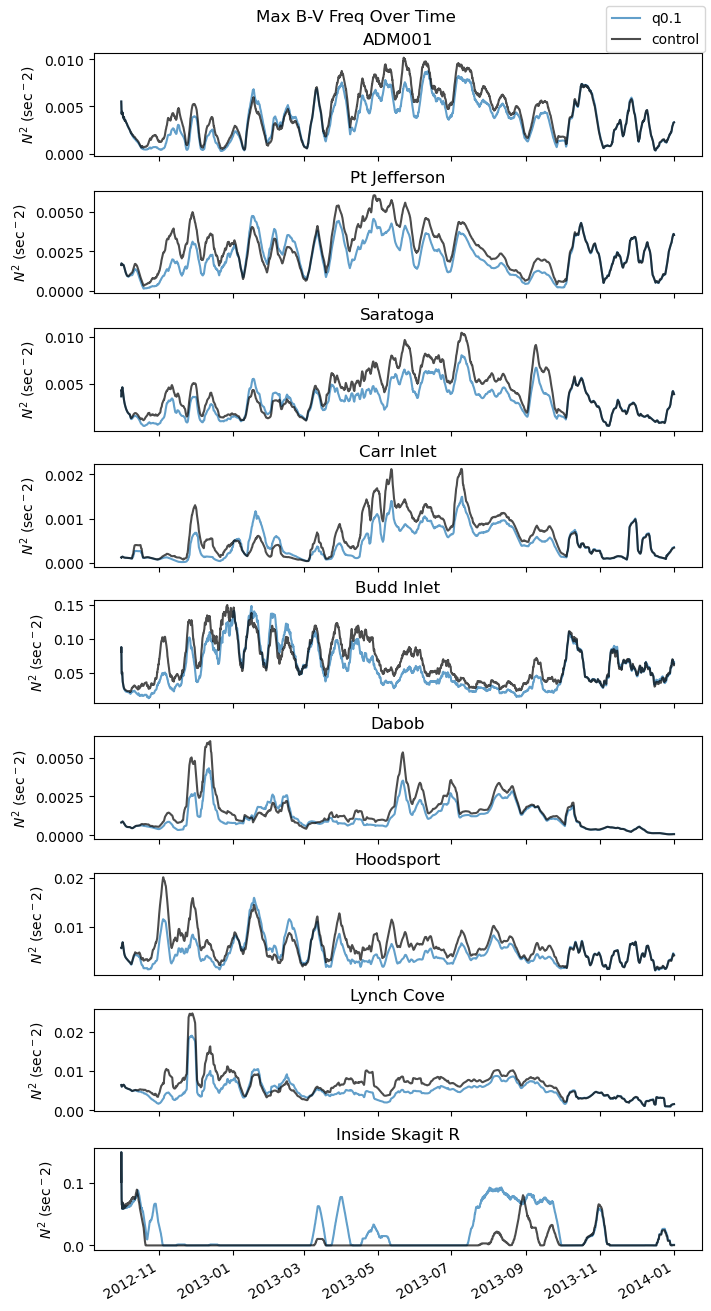

In [30]:
if len(sites):
    fig, axs = plt.subplots(len(sites), 1, constrained_layout=True, figsize=(7, int(1.5*len(sites))), dpi=100)
    with pd.ExcelWriter(out_file("sites.xlsx")) as writer:
        # Iterate over all the specified sites, along with a dedicated plot Axes per site
        for ax,(n,s) in zip(axs, sites.items()):
            #tsax, boxax = ax
            tsax = ax
            idx = np.nonzero(bf_data['node'][:] == n)[0][0]
            data = {}
            lbl = "{0} ({1})".format(s, n)
            df = None
            # Plot all the required variables on this Axes
            for v, t in zip(bf_variables, bf_variable_titles):
                data = bf_data[v][:,idx]
                if df is None:
                    df = pd.DataFrame({t: data}, index=dates)
                else:
                    df[t] = data
                if t == control_title:
                    color = 'black'
                else:
                    color = None
                df[t].rolling('7D').mean().plot(ax=tsax, color=color, alpha=0.7)
                #tsax.plot(dates, data, color=color, alpha=0.7, label=t)
            tsax.set(title=s, ylabel="$N^2$ (sec$^-2$)")

            #boxax.boxplot(data.values(), labels=data.keys())

            #df = pd.DataFrame(data, index=dates)
            df.to_excel(writer, sheet_name=lbl)

    # Implement autofmt_xdate() by hand because it breaks subplot title placement
    # Turn off xaxis labels on all but the last Axes
    for ax in axs[:-1]:
        ax.set_xticklabels(())
    # Orient the date labels properly on the lowest Axes
    for l in axs[-1].get_xticklabels():
        l.set_ha('right')
        l.set_rotation(30)

    fig.suptitle(f"{variable_type_name} B-V Freq Over Time")
    # One common legend. https://stackoverflow.com/a/46921590/413862
    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')

    fig.savefig(out_file("sites.png"))

In [10]:
bf_data.close()

In [29]:
bf_variables

['q0.1N2_max', 'controlN2_max']